In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import PIL.Image
import random
random.seed(0)
from image_patch_and_load_functions import *
from dice_calculation import *
import os

# 1. Load orginal images + segmentations and thick/thin predictions

## Prediction files (thick and thin)

In [3]:
result_path = "./results/sub15_thick_thin_10000minibatches/"

def sort_prediction_filenames(fnames):
    numbers = []
    for name in fnames:
        number = int(name.split('_')[-1].split('.')[0])
        numbers.append(number)
    correct_order = np.argsort(numbers)
    fnames_sorted = np.array(fnames)
    fnames_sorted = fnames_sorted[correct_order]
    return fnames_sorted

#####
# Training predictions file names
foldername = result_path + "thick/" + "training_results/"
train_thick_names = glob.glob(foldername  + '*.npy')
foldername = result_path + "thin/" + "training_results/"
train_thin_names = glob.glob(foldername + '*.npy')

# Sort them by ascending number
train_thick_names = sort_prediction_filenames(train_thick_names)
train_thin_names = sort_prediction_filenames(train_thin_names)

print("Sorted training filenames: ")
print(train_thick_names[:5])
print("+")
print(train_thin_names[:5])
print("...")

#####    
# Validation predictions file names
foldername = result_path + "thick/" + "validation_results/"
valid_thick_names = glob.glob(foldername + '*.npy')
foldername = result_path + "thin/" + "validation_results/"
valid_thin_names = glob.glob(foldername + '*.npy')

# Sort them by ascending number
valid_thick_names = sort_prediction_filenames(valid_thick_names)
valid_thin_names = sort_prediction_filenames(valid_thin_names)

print("\nSorted validation filenames: ")
print(valid_thick_names)
print("+")
print(valid_thin_names)

#####
# Test predictions file names
foldername = result_path + "thick/" + "test_results/"
test_thick_names = glob.glob(foldername + '*.npy')
foldername = result_path + "thin/" + "test_results/"
test_thin_names = glob.glob(foldername + '*.npy')

# Sort them by ascending number
test_thick_names = sort_prediction_filenames(test_thick_names)
test_thin_names = sort_prediction_filenames(test_thin_names)

print("\nSorted test filenames: ")
print(test_thick_names[:5])
print("+")
print(test_thin_names[:5])
print("...")

Sorted training filenames: 
['./results/sub15_thick_thin_10000minibatches/thick/training_results\\train_probabilities_1.npy'
 './results/sub15_thick_thin_10000minibatches/thick/training_results\\train_probabilities_2.npy'
 './results/sub15_thick_thin_10000minibatches/thick/training_results\\train_probabilities_3.npy'
 './results/sub15_thick_thin_10000minibatches/thick/training_results\\train_probabilities_4.npy'
 './results/sub15_thick_thin_10000minibatches/thick/training_results\\train_probabilities_5.npy']
+
['./results/sub15_thick_thin_10000minibatches/thin/training_results\\train_probabilities_1.npy'
 './results/sub15_thick_thin_10000minibatches/thin/training_results\\train_probabilities_2.npy'
 './results/sub15_thick_thin_10000minibatches/thin/training_results\\train_probabilities_3.npy'
 './results/sub15_thick_thin_10000minibatches/thin/training_results\\train_probabilities_4.npy'
 './results/sub15_thick_thin_10000minibatches/thin/training_results\\train_probabilities_5.npy']
...

## Original files (training and validation)

In [4]:
# Load the training images, masks and segmentations from the dataset
impaths_all = glob.glob(r'.\training\images\*.tif')
trainingsetsize = 15

#shuffle the images to take a random subset for training later
random.shuffle(impaths_all)

maskpaths_all = copy.deepcopy(impaths_all)
segpaths_all = copy.deepcopy(impaths_all)

#select the corresponding masks and segmentations
for i in range(len(impaths_all)):
    maskpaths_all[i] = impaths_all[i].replace('images','mask')
    maskpaths_all[i] = maskpaths_all[i].replace('.tif','_mask.gif')

    segpaths_all[i] = impaths_all[i].replace('images','1st_manual')
    segpaths_all[i] = segpaths_all[i].replace('training.tif','manual1.gif')
    
print("\n".join(impaths_all[:5]))

impaths = impaths_all # just to be compatible with the scripts
maskpaths = maskpaths_all
segpaths = segpaths_all


#load the training images
images, masks, segmentations = loadImages(impaths,maskpaths,segpaths)

print(images.shape)
print(masks.shape)
print(segmentations.shape)

.\training\images\31_training.tif
.\training\images\39_training.tif
.\training\images\37_training.tif
.\training\images\35_training.tif
.\training\images\21_training.tif
(20, 584, 565)
(20, 584, 565)
(20, 584, 565)


# 2. Exhaustive threshold search

## In training set

In [97]:
def optimal_thick_thin(ground_truth, mask, thick_prediction, thin_prediction, thick_low=0.65,
                       thick_high=0.95, thin_low=0.80, thin_high=0.99, steps=30):

    # Remove the padding from prediction
    thick_prediction = thick_prediction[16:-16,16:-16]
    thin_prediction = thin_prediction[16:-16,16:-16]

    # Normalize
    thick_prediction /= np.amax(thick_prediction)
    thin_prediction /= np.amax(thin_prediction)
    ground_truth = np.float32(ground_truth)
    ground_truth /= np.amax(ground_truth)
    mask = np.float32(mask)
    mask /= np.amax(mask)
    # Range of threshold values to be tested
    thick_limits = np.linspace(thick_low, thick_high, steps)
    thin_limits = np.linspace(thin_low, thin_high, steps)

    dice_scores = []
    lazy_thick_limits = []
    lazy_thin_limits = []

    for thick_limit in thick_limits:
#         print("Thick limit = {} \tMax. dice score= {}".format(thick_limit, max_dice), end='\r')
        for thin_limit in thin_limits:
            thick_thresholded = copy.deepcopy(thick_prediction)
            thin_thresholded = copy.deepcopy(thin_prediction)

            thick_thresholded[thick_thresholded>thick_limit] = 1
            thick_thresholded[thick_thresholded<=thick_limit] = 0

            thin_thresholded[thin_thresholded>thin_limit] = 1
            thin_thresholded[thin_thresholded<=thin_limit] = 0

            fusion = copy.deepcopy(thick_thresholded + thin_thresholded)
            fusion[fusion==2] = 1
            d = dice_score(ground_truth, mask, fusion)
            dice_scores.append(d)
            lazy_thick_limits.append(thick_limit)
            lazy_thin_limits.append(thin_limit)
            
    # Find the optimal threshold (maximum dice score)
    opt_pos = np.argmax(dice_scores)
    # Apply optimal threshold to thick segmentations
    opt_thick_limit = lazy_thick_limits[opt_pos]
    opt_thick_seg = copy.deepcopy(thick_prediction)
    opt_thick_seg[opt_thick_seg>opt_thick_limit] = 1
    opt_thick_seg[opt_thick_seg<=opt_thick_limit] = 0
    # Apply optimal threshold to thin segmentations
    opt_thin_limit = lazy_thick_limits[opt_pos]
    opt_thin_seg = copy.deepcopy(thin_prediction)
    opt_thin_seg[opt_thin_seg>opt_thin_limit] = 1
    opt_thin_seg[opt_thin_seg<=opt_thin_limit] = 0
    # Fuse the two segmentations
    fusion = opt_thick_seg + opt_thin_seg
    fusion[fusion==2] = 1
    opt_dice = dice_scores[opt_pos]

    return fusion, opt_thick_limit, opt_thin_limit, opt_dice

In [100]:
train_opt_segmentations = []
train_opt_thresholds = []
train_opt_dice_scores = []
for i in range(trainingsetsize):
    thick_prediction = np.load(train_thick_names[i])
    thin_prediction = np.load(train_thin_names[i])
    fusion, opt_thick_limit, opt_thin_limit, opt_dice = optimal_thick_thin(segmentations[i,:,:], masks[i,:,:], thick_prediction, thin_prediction)
    train_opt_segmentations.append(fusion)
    train_opt_thresholds.append((opt_thick_limit, opt_thin_limit))
    train_opt_dice_scores.append(opt_dice)
    print("Training image {} \tMax. Dice score = {} \tThick threshold = {} \tThin threshold = {} ".format(i+1, opt_dice, opt_thick_limit, opt_thin_limit) ) 

mean_dice_score_training = np.mean(train_opt_dice_scores)
mean_thick_threshold_training = np.mean(train_opt_thresholds[0])
mean_thin_threshold_training = np.mean(train_opt_thresholds[1])
print("\nMean Dice score: {}".format(mean_dice_score_training))
print("Mean Thick threshold: {}".format(mean_thick_threshold_training))
print("Mean Thin threshold: {}".format(mean_thin_threshold_training))

Training image 1 	Max. Dice score = 0.7814365397788433 	Thick threshold = 0.8258620689655172 	Thin threshold = 0.8258620689655172 
Training image 2 	Max. Dice score = 0.7782820364716561 	Thick threshold = 0.8362068965517241 	Thin threshold = 0.8362068965517241 
Training image 3 	Max. Dice score = 0.8109115103127079 	Thick threshold = 0.8155172413793104 	Thin threshold = 0.8155172413793104 
Training image 4 	Max. Dice score = 0.8140622160545836 	Thick threshold = 0.8362068965517241 	Thin threshold = 0.8362068965517241 
Training image 5 	Max. Dice score = 0.8077817968520872 	Thick threshold = 0.8258620689655172 	Thin threshold = 0.8258620689655172 
Training image 6 	Max. Dice score = 0.8024816283197584 	Thick threshold = 0.8362068965517241 	Thin threshold = 0.8362068965517241 
Training image 7 	Max. Dice score = 0.8032420448143639 	Thick threshold = 0.8051724137931034 	Thin threshold = 0.8051724137931034 
Training image 8 	Max. Dice score = 0.7742872288934474 	Thick threshold = 0.8465517

## Validation set

In [101]:
valid_opt_segmentations = []
valid_opt_thresholds = []
valid_opt_dice_scores = []
for i in range(5):
    thick_prediction = np.load(valid_thick_names[i])
    thin_prediction = np.load(valid_thin_names[i])
    fusion, opt_thick_limit, opt_thin_limit, opt_dice = optimal_thick_thin(segmentations[trainingsetsize+i,:,:], masks[trainingsetsize+i,:,:], thick_prediction, thin_prediction)
    valid_opt_segmentations.append(fusion)
    valid_opt_thresholds.append((opt_thick_limit, opt_thin_limit))
    valid_opt_dice_scores.append(opt_dice)
    print("Validation image {} \tMax. Dice score = {} \tThick threshold = {} \tThin threshold = {} ".format(i+1, opt_dice, opt_thick_limit, opt_thin_limit) ) 

mean_dice_score_valid = np.mean(valid_opt_dice_scores)
mean_thick_threshold_valid = np.mean(valid_opt_thresholds[0])
mean_thin_threshold_valid = np.mean(valid_opt_thresholds[1])
print("\nMean Dice score: {}".format(mean_dice_score_valid))
print("Mean Thick threshold: {}".format(mean_thick_threshold_valid))
print("Mean Thin threshold: {}".format(mean_thin_threshold_valid))

Validation image 1 	Max. Dice score = 0.8244895730974997 	Thick threshold = 0.7948275862068965 	Thin threshold = 0.7948275862068965 
Validation image 2 	Max. Dice score = 0.792437171877537 	Thick threshold = 0.8051724137931034 	Thin threshold = 0.8051724137931034 
Validation image 3 	Max. Dice score = 0.7974810919596196 	Thick threshold = 0.7741379310344827 	Thin threshold = 0.7741379310344827 
Validation image 4 	Max. Dice score = 0.7156360656697199 	Thick threshold = 0.7741379310344827 	Thin threshold = 0.7741379310344827 
Validation image 5 	Max. Dice score = 0.8022210566297093 	Thick threshold = 0.8155172413793104 	Thin threshold = 0.8155172413793104 

Mean Dice score: 0.786452991846817
Mean Thick threshold: 0.7948275862068965
Mean Thin threshold: 0.8051724137931034


# 3. Apply the optimal limit (threshold) to the test set

In [103]:
# Assume that optimal is (puts more weight to the validation set):
opt_thick_threshold = (mean_thick_threshold_training + mean_thick_threshold_valid) / 2.
opt_thin_threshold = (mean_thin_threshold_training + mean_thin_threshold_valid) / 2.

print("Optimal thick threshold = ", opt_thick_threshold)
print("Optimal thin threshold = ", opt_thin_threshold)

Optimal thick threshold =  0.8103448275862069
Optimal thin threshold =  0.8206896551724138


In [106]:
# Try using only the valaditation threshold
opt_thick_threshold = mean_thick_threshold_valid
opt_thin_threshold = mean_thin_threshold_valid

print("Optimal thick threshold = ", opt_thick_threshold)
print("Optimal thin threshold = ", opt_thin_threshold)

Optimal thick threshold =  0.7948275862068965
Optimal thin threshold =  0.8051724137931034


In [107]:
# Create directory to store predictions for submission
dirName = "submission"
exists = os.path.isdir("./submission/")
if not(exists):
    os.mkdir(dirName)
    print("Directory ", dirName, " was created")
else:
    print("Directory ", dirName, " already exists")

Directory  submission  already exists


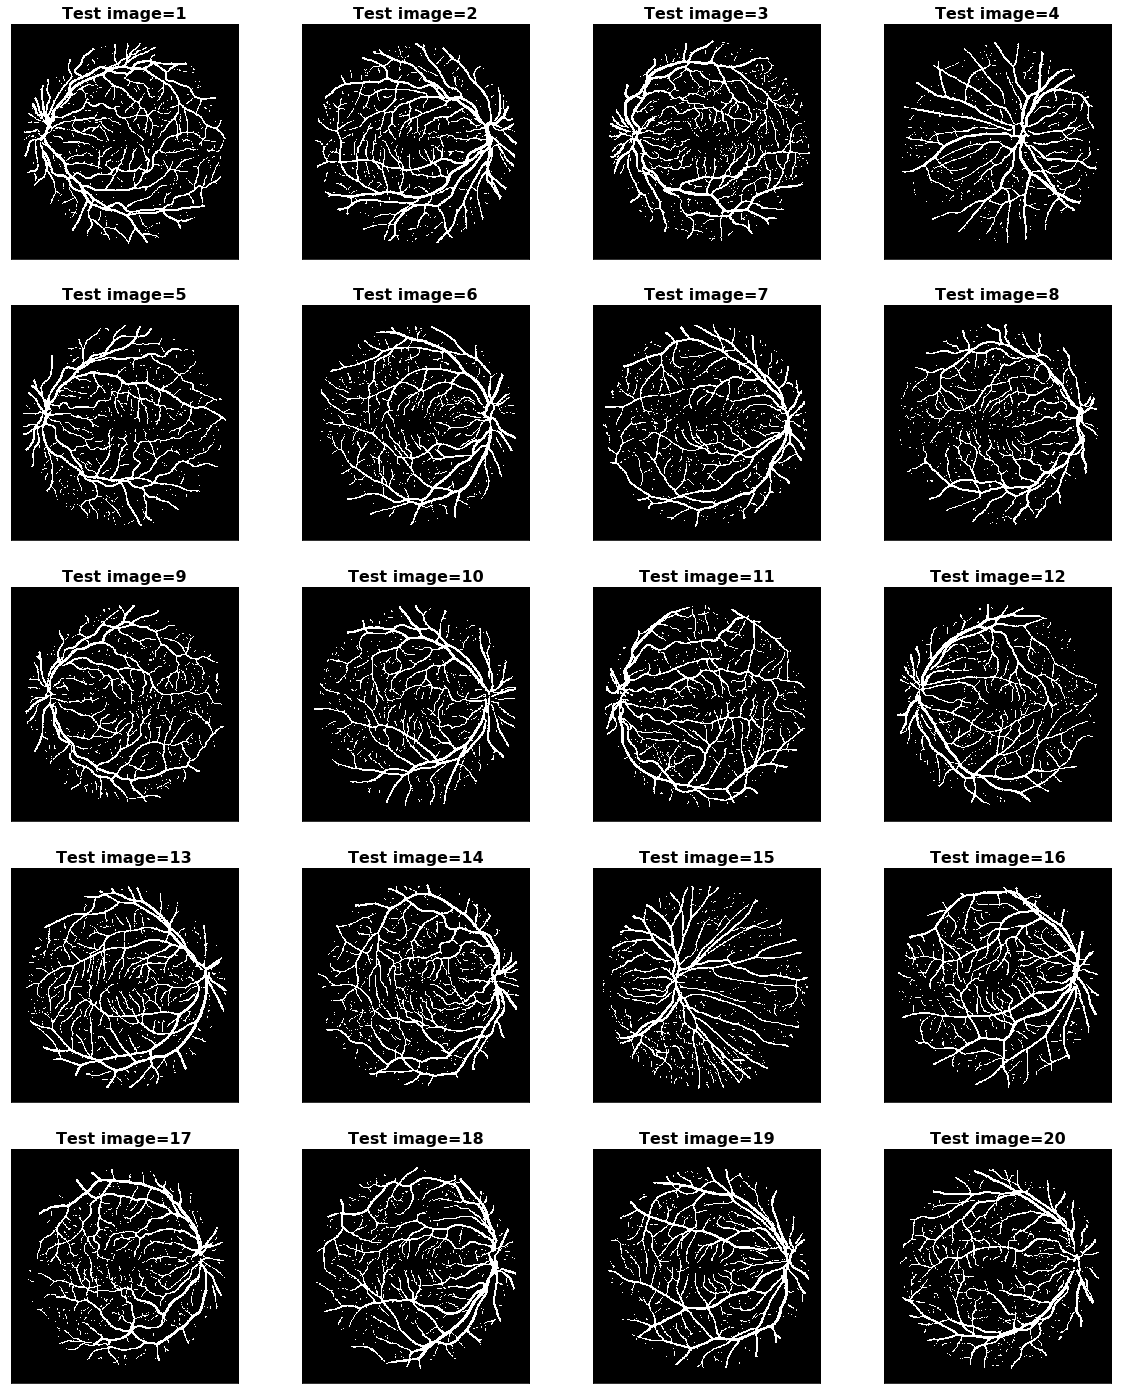

In [108]:
plt.rcParams["figure.figsize"] = (20,25)

nrows = 5
ncols = 4

# Thresholded test images
for i in range(len(test_thick_names)):
    plt.subplot(nrows, ncols, i+1)
    # Load prediction for test image i
    thick_test = np.load(test_thick_names[i])
    thin_test = np.load(test_thin_names[i])
    # Normalize
    thick_test /= np.amax(thick_test)
    thin_test /= np.amax(thin_test)
    # Apply the optimal threshold 
    thick_test[thick_test>opt_thick_threshold] = 1
    thick_test[thick_test<=opt_thick_threshold] = 0
    thin_test[thin_test>opt_thin_threshold] = 1
    thin_test[thin_test<=opt_thin_threshold] = 0
    # Fuse
    fusion_test = thick_test + thin_test
    fusion_test[fusion_test==2] = 1
    # Show image
    plt.imshow(fusion_test, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Test image={i+1}", fontsize=16, fontweight="bold")
    
    # Save each image as PNG file
    img = PIL.Image.fromarray(np.uint8(fusion_test[16:-16,16:-16]*255))
    img.save("./submission/{}.png".format(i+1), "PNG")
    
plt.show()